### Air Quality Monitor and Comparison

1. Dataset

Name: Air Quality Data - Updated Hourly
This website provides global air quality data updated hourly on the pollutants of PM2.5, PM10, O3 (Ozone), NO2 (Nitrogen dioxide), SO2 (Sulfur dioxide), CO (Carbon monoxide)

2. Research Questions

How do hourly air pollution patterns (PM₂.₅, NO₂, O₃) vary across major cities, and when do cities experience statistically significant spikes relative to their typical baseline?
We will focus on 6 major cities that allows us to have strong diversity for meaningful comparison across the globe
NYC
London
Hong Kong
Delhi
São Paulo
Tokyo

3. Notebook Link

4. Target Visualization
To be updated
5. Known Unknowns

Known:
Timestamped hourly pollutant readings for (PM2.5, NO2, O3), which allows us to conduct pattern analysis and produce day-of week comparisons, spike detection, and form rolling averages
All pollutants share the same measurement of µg/m³
Geographic coordinates, which allows us to monitor stations for cross-city comparisons, spatial clustering, and mapping in Streamlit
Clearly specified pollutant types allows us to compare traffic-related and climate-related patterns
Real-time data enables a live dashboard for trend and monitoring applications in our application development

Unknown:
Data Quality may vary as OpenAQ aggregates from multiple providers, such as government monitors, low-cost sensors, and private contributors. We are unsure if all monitors are calibrated equally, which may reflect monitoring quality difference when using the data for cross-city comparisons
Station placement bias because the stations are not randomly distributed, as they may be placed near highways, industrial zones, residential areas, etc. that may not represent the entire city fairly. This affects spike interpretation and baseline calculation. We may need to consider pulling data from multiple locations within a city with city-level aggregates, using median values and standard deviations to make the cities more comparable
The definition of spike needs to be constructed
No direct causal variables of traffic counts, weather (temperature and wind), policy changes, industrial output, wildfire data. We may need another set of data(s) to identify the direct causes

6. Anticipated Challenges

Making sure the time stamps are consistent across the data and making sure the time zones are correct
Computing the baseline and spikes correctly, by using city-level hourly aggregation, rolling baseline, and rolling variability estimates. This requires computing the z-score or robust z-score
Need to code to log data pull times and timestamps of a specific time to produce live data on our application


## To be Updated

In [17]:
import requests
import pandas as pd

base_url = "https://data.cityofnewyork.us/resource/bkwf-xfky.json"

def fetch_all_socrata(url, batch_size=50000, params=None):
    all_rows = []
    offset = 0
    params = params.copy() if params else {}

    while True:
        p = params.copy()
        p["$limit"] = batch_size
        p["$offset"] = offset

        r = requests.get(url, params=p, timeout=60)
        r.raise_for_status()
        batch = r.json()

        if not batch:  
            break

        all_rows.extend(batch)
        offset += batch_size
        print(f"Fetched {len(all_rows)} rows...")

    return pd.json_normalize(all_rows)


df = fetch_all_socrata(base_url, batch_size=50000)

print("Total rows:", len(df))
df.head()


Fetched 50000 rows...
Fetched 100000 rows...
Fetched 150000 rows...
Fetched 165758 rows...
Total rows: 165758


,sample_number,sample_date,sample_time,sample_site,sample_class,residual_free_chlorine_mg_l,turbidity_ntu,coliform_quanti_tray_mpn_100ml,e_coli_quanti_tray_mpn_100ml,fluoride_mg_l
0,202436678,2024-12-31T00:00:00.000,09:47:00.000,51050,Compliance,0.50,0.69,<1,<1,NaN
1,202436679,2024-12-31T00:00:00.000,10:28:00.000,58350,Compliance,0.46,0.82,<1,<1,NaN
2,202436680,2024-12-31T00:00:00.000,09:08:00.000,59350,Compliance,0.39,0.75,<1,<1,NaN
3,202436675,2024-12-31T00:00:00.000,08:45:00.000,78450,Compliance,0.32,0.70,<1,<1,NaN
4,202426025,2024-10-01T00:00:00.000,08:36:00.000,10750,Compliance,0.84,0.47,<1,<1,0.71


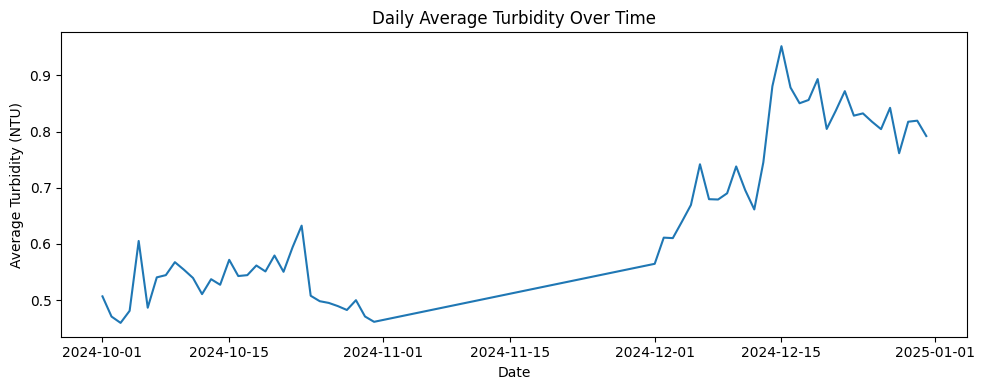

In [ ]:
import matplotlib.pyplot as plt


df["sample_date"] = pd.to_datetime(df["sample_date"], errors="coerce")
df["sample_time"] = df["sample_time"].astype(str)

df["sample_dt"] = pd.to_datetime(
    df["sample_date"].dt.strftime("%Y-%m-%d") + " " + df["sample_time"].str.slice(0, 8),
    errors="coerce"
)


df["turbidity_ntu"] = pd.to_numeric(df["turbidity_ntu"], errors="coerce")


daily = (
    df[["sample_dt", "turbidity_ntu"]]
    .dropna()
    .assign(date=lambda x: x["sample_dt"].dt.floor("D"))
    .groupby("date", as_index=False)["turbidity_ntu"]
    .mean()
)


plt.figure(figsize=(10, 4))
plt.plot(daily["date"], daily["turbidity_ntu"])
plt.xlabel("Date")
plt.ylabel("Average Turbidity (NTU)")
plt.title("Daily Average Turbidity Over Time")
plt.tight_layout()
plt.show()
